In [197]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Metropolis Monte-Carlo implementation of Ising model

**Add some info/diagram about metropolis algorithm!!**

In [198]:
# General metropolis algorithm for Ising model.
class MetropolisIsing:
    """ 
    Implementation of Ising model, i.e. nearest-neighbor (nn) interactions, 
    using a vectorized Metropolis Monte-Carlo (MC) algorithm.
    Works for binary spin configurations on a 1d chain, 2d lattice, and Cayley graph.
    """
    def __init__(self, T, J=1.0, H=0.0):
        """
        Args:
            T (float): temperature
            J (float): strength of nearest neighbor interactions
            H (float): strength of external magnetic field
        """
        self.beta = 1 / T   # Set Boltzmann constant to 1.
        self.J = J
        self.H = H
    
    def nn_alignment(self):
        """ 
        Must be implemented in child classes.
        Intended to return net alignment of the nearest-neighbor (nn) spins, 
        using periodic boundary conditions.
        """
        raise NotImplementedError("Function must be called from a child class.")
    
    def update_spins(self, X_spins):
        """ 
        Update spins in the lattice using metropolis algorithm.
        Args:
            X_spins (1d or 2d array): current state of the spin system
        
        Returns:
            X_result (1d or 2d array): updated state of the spin system
        """
        # Calculate change in energy required to flip each spin.
        X_nn = self.nn_alignment(X_spins)
        X_Ei = - self.J * X_spins * X_nn - self.H * X_spins
        X_Ef = - X_Ei
        X_deltaE = X_Ef - X_Ei

        X_result = X_spins.copy()
        X_flip = - X_spins

        # If deltaE < 0, accept the spin flip.
        X_result[X_deltaE < 0] = X_flip[X_deltaE < 0]

        # If deltaE > 0, accept the spin flip with probability
        # given by Boltzmann factor.
        X_prob = np.random.rand(*X_spins.shape)
        X_prob_c = np.exp(- self.beta * X_deltaE)
        X_result[(X_deltaE > 0) & (X_prob < X_prob_c)] = X_flip[
            (X_deltaE > 0) & (X_prob < X_prob_c)]

        return X_result
    
    def net_magnetization(self, X_spins):
        """ 
        Calculate net magnetization of the spin system. This is simply the sum
        of all spin values in the lattice.
        Args:
            X_spins (1d or 2d array): current state of the spin system
        
        Returns:
            (float): net magnetization
        """
        return np.sum(X_spins)
    
    def net_energy(self, X_spins):
        """ 
        Calculate net energy of the spin lattice. This is the sum of all energies
        due to nn interactions and the external magnetic field.
        Args:
            X_spins (1d or 2d array): current state of the spin system
        
        Returns:
            (float): net energy
        """
        X_nn = self.nn_alignment(X_spins)
        X_E = - self.J * X_spins * X_nn - self.H * X_spins
        return np.sum(X_E) / 2


# Ising model on 1D chain

In [199]:
class Ising1D(MetropolisIsing):
    """ 
    Metrpopolis MC implementation of Ising model on 1d spin chain.
    """
    def nn_alignment(self, X_chain):
        """ 
        Sum the spin values of the 2 nearest neighbors (nn) for each spin in
        the lattice. This represents the net alignment of the nn spins.
        Args:
            X_chain (1darray): current state of the spin system

        Returns:
            X_nn (1darray): sum of nn spin values
        """
        X_nn = np.zeros_like(X_chain)
        X_nn[:-1] += X_chain[1:]           # Left neighbor contribution
        X_nn[1:]  += X_chain[:-1]          # Right neighbor contribution

        # Periodic boundary conditions.
        X_nn[-1] += X_chain[0]
        X_nn[0] += X_chain[-1]

        return X_nn

iterations: 8


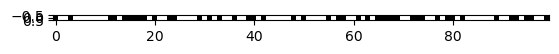

In [202]:
# Simulate time evolution of a 1D Ising model with nn interactions.
# Start with a random state with 75% spins down.
Ising1d = Ising1D(T=0.1, J=1, H=0.1)
np.random.seed(0)
frames = []
dim = 100
chain1d = np.random.choice([-1, 1], size=dim)
array1d = chain1d.reshape(1, -1)
frames.append(array1d)
fig = plt.figure()
img = plt.imshow(array1d, cmap="gray")

for i in range(50):
    chain1d = Ising1d.update_spins(chain1d)
    array1d = chain1d.reshape(1, -1)
    frames.append(array1d)
    if np.all(chain1d == 1):
        break
print("iterations:", i + 1)

def animate(frame):
    img.set_array(frame)

animation = FuncAnimation(fig, animate, frames=frames, interval=len(frames))
HTML(animation.to_jshtml())

No external field (H = 0).


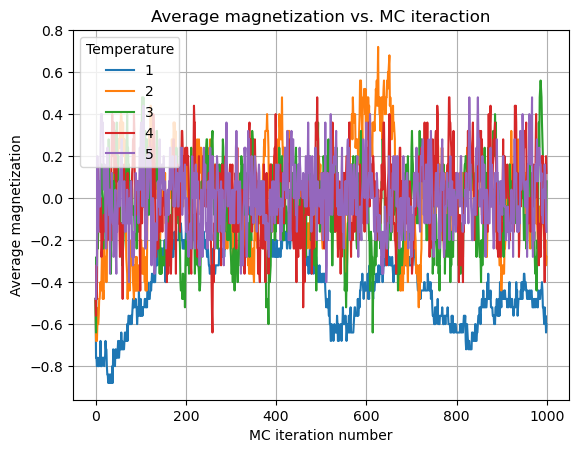

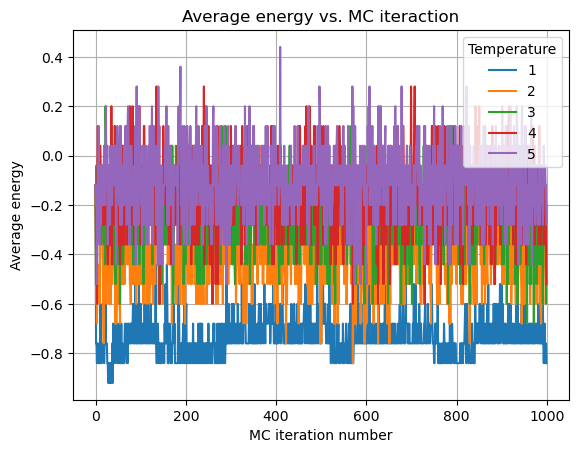

In [203]:
# Plot average values vs MC iteration for various temperatures, with 0 external field.
# Start with a random state with 75% spins down.
temps = np.arange(1, 6, 1)
total_iter = 1000
all_iter = []
all_mag, all_energies = [], []
dim = 50
chain1d = np.random.choice([-1, 1], size=dim, p=[0.75, 0.25])

for temp in temps:
    Ising_chain = Ising1D(T=temp, J=1, H=0.0)
    np.random.seed(0)
    iteration = np.arange(0, total_iter)
    avg_mag, avg_energy = [], []

    prev = chain1d
    for i in range(total_iter):
        current = Ising_chain.update_spins(prev)
        avg_mag.append(Ising_chain.net_magnetization(prev) / dim)
        avg_energy.append(Ising_chain.net_energy(prev) / dim)
        prev = current

    all_iter.append(iteration)
    all_mag.append(avg_mag)
    all_energies.append(avg_energy)

print("No external field (H = 0).")
plt.figure(0)
for i in range(len(all_iter)):
    temp = temps[i]
    plt.plot(all_iter[i], all_mag[i], label=str(temp))

plt.xlabel('MC iteration number')
plt.ylabel('Average magnetization')
plt.title('Average magnetization vs. MC iteraction')
plt.grid()
plt.legend(title="Temperature")
plt.show()

plt.figure(1)
for i in range(len(all_iter)):
    temp = temps[i]
    plt.plot(all_iter[i], all_energies[i], label=str(temp))

plt.xlabel('MC iteration number')
plt.ylabel('Average energy')
plt.title('Average energy vs. MC iteraction')
plt.grid()
plt.legend(title="Temperature")
plt.show()

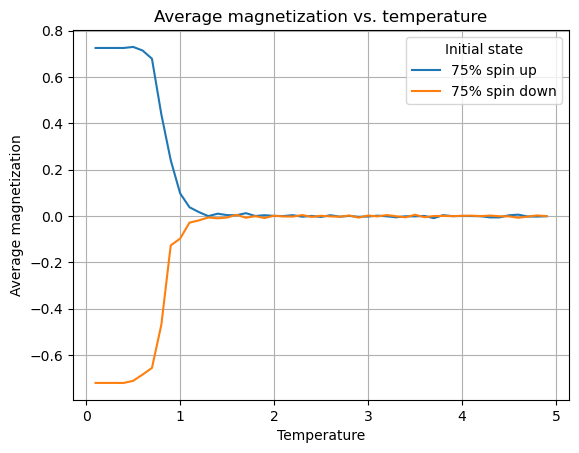

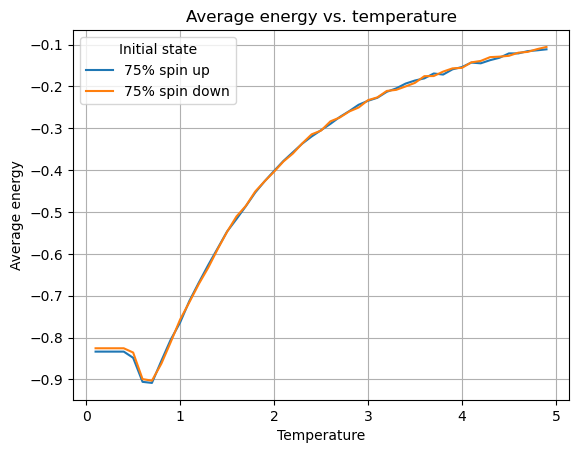

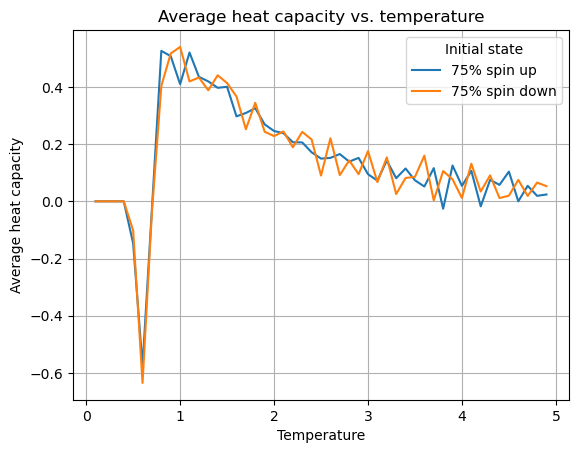

In [219]:
# Plot equilibrium average values as a function of temperature, with 0 external field.
# Start with random state with 75% spins up/down.
delta_temp = 0.1
temps = np.arange(0.1, 5., delta_temp)
total_iter = 100
trials = 50
l_mag_d, l_energy_d, l_heat_cap_d = [], [], []
l_mag_u, l_energy_u, l_heat_cap_u = [], [], []
dim = 2500

np.random.seed(0)
chain_down = np.random.choice([-1, 1], size=dim, p=[0.75, 0.25])
chain_up = np.random.choice([-1, 1], size=dim, p=[0.25, 0.75])

for temp in temps:
    Ising_chain = Ising1D(T=temp, J=1, H=0.0)
    prev_d = chain_down
    prev_u = chain_up
    
    trial_energy_d, trial_mag_d = [], []
    trial_energy_u, trial_mag_u = [], []
    for t in range(trials):     # Multiple trials to average out statistical fluctuations.
        for i in range(total_iter):
            current_d = Ising_chain.update_spins(prev_d)
            current_u = Ising_chain.update_spins(prev_u)
            if np.array_equal(current_d, prev_d) \
                and np.array_equal(current_u, prev_u):
                break
            prev_d = current_d
            prev_u = current_u

        trial_energy_d.append(Ising_chain.net_energy(prev_d) / dim)
        trial_mag_d.append(Ising_chain.net_magnetization(prev_d) / dim)
        trial_energy_u.append(Ising_chain.net_energy(prev_u) / dim)
        trial_mag_u.append(Ising_chain.net_magnetization(prev_u) / dim)

    avg_mag_d = sum(trial_mag_d) / trials
    avg_energy_d = sum(trial_energy_d) / trials
    if not l_energy_d:
        heat_cap_d = 0
    else:
        heat_cap_d = (avg_energy_d - l_energy_d[-1]) / delta_temp
    l_mag_d.append(avg_mag_d)
    l_energy_d.append(avg_energy_d)
    l_heat_cap_d.append(heat_cap_d)

    avg_mag_u = sum(trial_mag_u) / trials
    avg_energy_u = sum(trial_energy_u) / trials
    if not l_energy_u:
        heat_cap_u = 0
    else:
        heat_cap_u = (avg_energy_u - l_energy_u[-1]) / delta_temp
    l_mag_u.append(avg_mag_u)
    l_energy_u.append(avg_energy_u)
    l_heat_cap_u.append(heat_cap_u)


plt.figure(0)
plt.plot(temps, l_mag_u, label="75% spin up")
plt.plot(temps, l_mag_d, label="75% spin down")
plt.xlabel('Temperature')
plt.ylabel('Average magnetization')
plt.title('Average magnetization vs. temperature')
plt.grid()
plt.legend(title="Initial state")
plt.show()

plt.figure(1)
plt.plot(temps, l_energy_u, label="75% spin up")
plt.plot(temps, l_energy_d, label="75% spin down")
plt.xlabel('Temperature')
plt.ylabel('Average energy')
plt.title('Average energy vs. temperature')
plt.grid()
plt.legend(title="Initial state")
plt.show()

plt.figure(2)
plt.plot(temps, l_heat_cap_u, label="75% spin up")
plt.plot(temps, l_heat_cap_d, label="75% spin down")
plt.xlabel('Temperature')
plt.ylabel('Average heat capacity')
plt.title('Average heat capacity vs. temperature')
plt.grid()
plt.legend(title="Initial state")
plt.show()

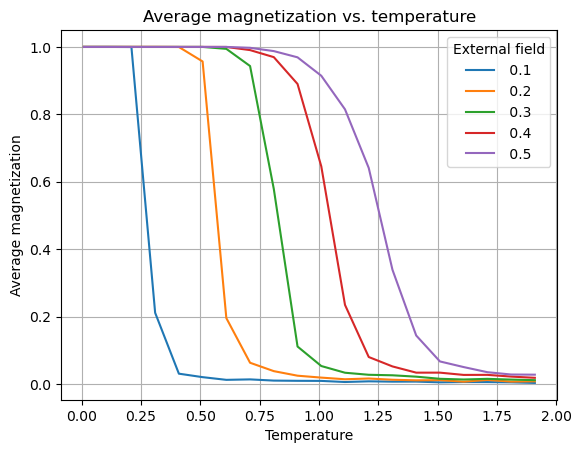

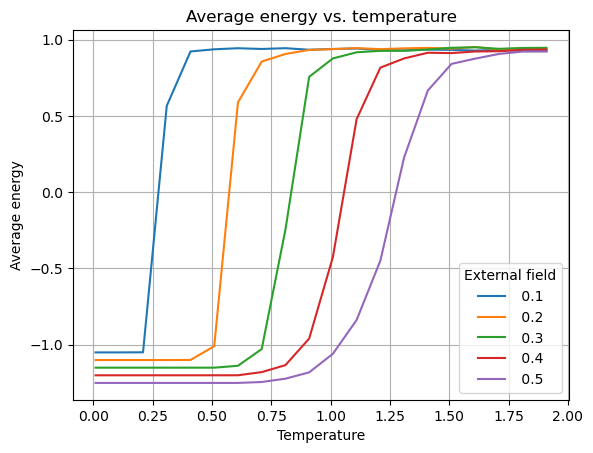

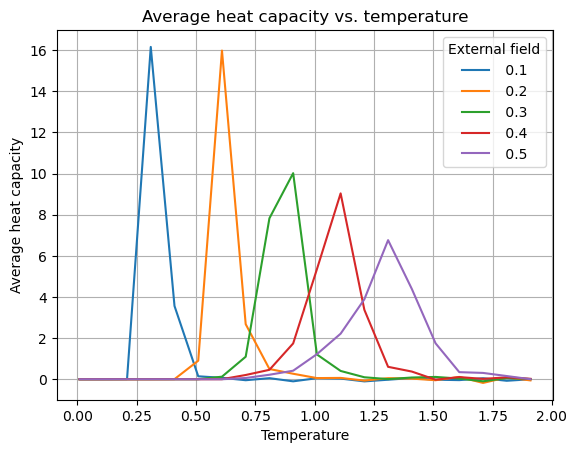

In [216]:
# Plot equilibrium average values as a function of temperature for various 
# external field strengths.
# Start with random state with 75% spins down.
ext_field = np.arange(0.1, 0.6, 0.1)
delta_temp = 0.1
temps = np.arange(0.01, 2., delta_temp)
total_iter = 100
trials = 10
l_all_mag, l_all_energy, l_all_heat_cap = [], [], []
dim = 2500

for field_val in ext_field:
    np.random.seed(0)
    chain1d = np.random.choice([-1, 1], size=dim, p=[0.75, 0.25])
    l_mag, l_energy, l_heat_cap = [], [], []

    for temp in temps:
        Ising_chain = Ising1D(T=temp, J=1, H=field_val)
        prev = chain1d
        trial_energy, trial_mag = [], []
        for t in range(trials):     # Multiple trials to average out statistical fluctuations.
            for i in range(total_iter):
                current = Ising_chain.update_spins(prev)
                if np.array_equal(current, prev):
                    break
                prev = current
            trial_energy.append(Ising_chain.net_energy(current) / dim)
            trial_mag.append(Ising_chain.net_magnetization(current) / dim)

        avg_mag = sum(trial_mag) / trials
        avg_energy = sum(trial_energy) / trials
        if not l_energy:
            heat_cap = 0
        else:
            heat_cap = (avg_energy - l_energy[-1]) / delta_temp
        l_mag.append(avg_mag)
        l_energy.append(avg_energy)
        l_heat_cap.append(heat_cap)

    l_all_mag.append(l_mag)
    l_all_energy.append(l_energy)
    l_all_heat_cap.append(l_heat_cap)

plt.figure(0)
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_mag[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average magnetization')
plt.title('Average magnetization vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()

plt.figure(1)
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_energy[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average energy')
plt.title('Average energy vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()

plt.figure(2)
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_heat_cap[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average heat capacity')
plt.title('Average heat capacity vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()


---
# Ising model on 2D lattice

In [99]:
class Ising2DLattice(MetropolisIsing):
    """ 
    Metropolis MC implementation of Ising model on a 2D lattice.
    """
    def nn_alignment(self, X_lattice):
        """ 
        Sum the spin values of the 4 nearest neighbors (nn) for each spin in
        the lattice. This represents the net alignment of the nn spins.
        Args:
            X_lattice (2d array): current state of the spin system

        Returns:
            X_nn (2d array): sum of nn spin values
        """
        X_nn = np.zeros_like(X_lattice)
        X_nn[:, :-1] += X_lattice[:, 1:]    # Left nn contribution
        X_nn[:, 1:] += X_lattice[:, :-1]    # Right nn contribution
        X_nn[:-1, :] += X_lattice[1:, :]    # Lower nn contribution
        X_nn[1:, :] += X_lattice[:-1, :]    # Upper nn contribution

        # Periodic boundary conditions
        X_nn[:, 0] += X_lattice[:, -1]      # Right-end to left-end
        X_nn[:, -1] += X_lattice[:, 0]      # Left-end to right-end
        X_nn[0, :] += X_lattice[-1, :]      # Bottom-end to top-end
        X_nn[-1, :] += X_lattice[-1, :]     # Top-end to bottom-end

        return X_nn


iterations: 78


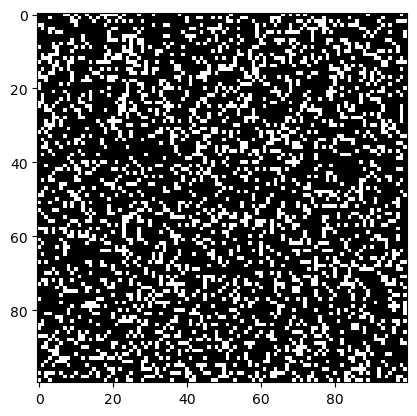

In [173]:
# Simulate time evolution of a 2D Ising model with nn interactions.
# Start with a random state with 75% spins down.
Ising2d = Ising2DLattice(T=0.1, J=1, H=0.1)
np.random.seed(0)

frames = []
dim = 100
lattice2d = np.random.choice([-1, 1], size=(dim, dim), p=[0.75, 0.25])
frames.append(lattice2d)
fig = plt.figure()
img = plt.imshow(lattice2d, cmap="gray")

iterations = 200
prev = lattice2d
for i in range(iterations):
    current = Ising2d.update_spins(prev)
    frames.append(current)
    if np.array_equal(current, prev):
        break
    prev = current
print("iterations:", i + 1)

# Animate the simulation.
def animate(frame):
    img.set_array(frame)

animation = FuncAnimation(fig, animate, frames=frames, interval=len(frames))
HTML(animation.to_jshtml())

No external field (H = 0).


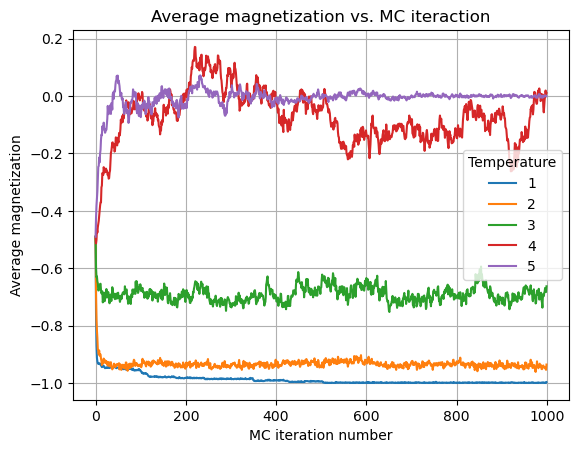

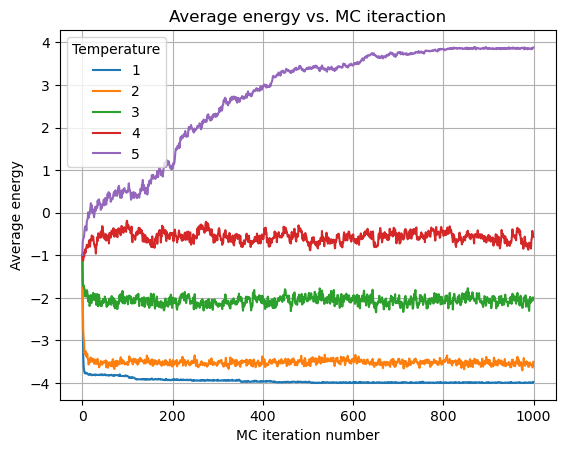

In [ ]:
# Plot average values vs MC iteration for various temperatures, with 0 external field.
# Start with a random state with 75% spins down.
temps = np.arange(1, 6, 1)
total_iter = 1000
all_iter = []
all_mag, all_energies = [], []
dim = 50
lattice2d = np.random.choice([-1, 1], size=(dim, dim), p=[0.75, 0.25])
# lattice2d = - np.ones((dim,dim))

for temp in temps:
    Ising2d = Ising2DLattice(T=temp, J=1, H=0.0)
    np.random.seed(0)
    iteration = np.arange(0, total_iter)
    avg_mag, avg_energy = [], []

    prev = lattice2d
    for i in range(total_iter):
        current = Ising2d.update_spins(prev)
        avg_mag.append(Ising2d.net_magnetization(prev) / (dim ** 2))
        avg_energy.append(Ising2d.net_energy(prev) / (dim ** 2))
        prev = current

    all_iter.append(iteration)
    all_mag.append(avg_mag)
    all_energies.append(avg_energy)

print("No external field (H = 0).")
plt.figure(0)
for i in range(len(all_iter)):
    temp = temps[i]
    plt.plot(all_iter[i], all_mag[i], label=str(temp))

plt.xlabel('MC iteration number')
plt.ylabel('Average magnetization')
plt.title('Average magnetization vs. MC iteraction')
plt.grid()
plt.legend(title="Temperature")
plt.show()

plt.figure(1)
for i in range(len(all_iter)):
    temp = temps[i]
    plt.plot(all_iter[i], all_energies[i], label=str(temp))

plt.xlabel('MC iteration number')
plt.ylabel('Average energy')
plt.title('Average energy vs. MC iteraction')
plt.grid()
plt.legend(title="Temperature")
plt.show()

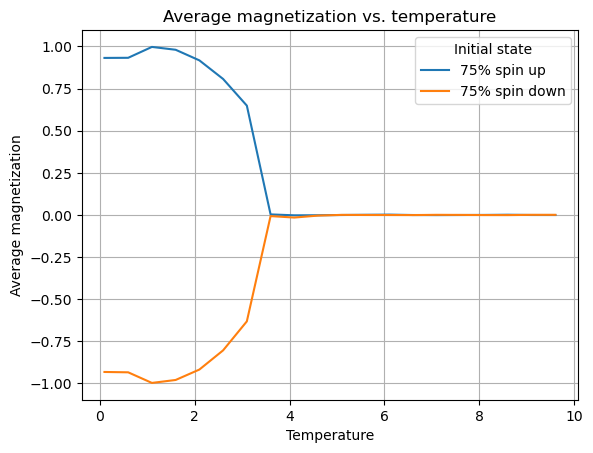

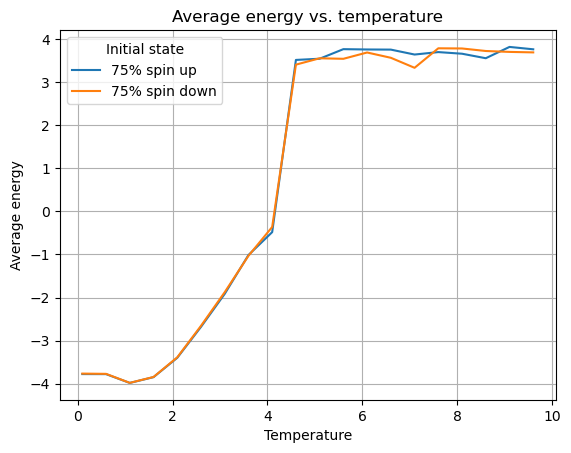

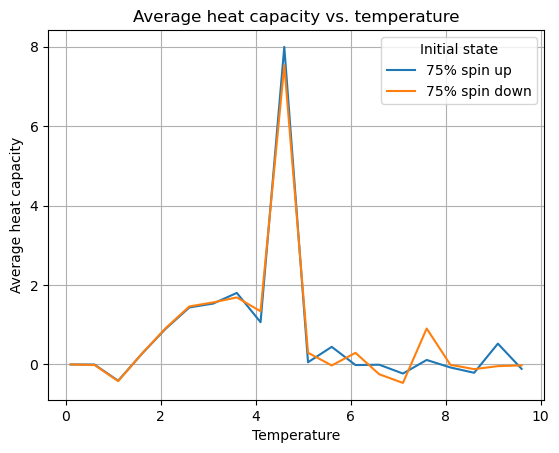

In [221]:
# Plot equilibrium average values as a function of temperature, with 0 external field.
# Start with random state with 75% spins up/down.
delta_temp = 0.5
temps = np.arange(0.1, 10., delta_temp)
total_iter = 100
trials = 50
l_mag_d, l_energy_d, l_heat_cap_d = [], [], []
l_mag_u, l_energy_u, l_heat_cap_u = [], [], []
dim = 50

np.random.seed(0)
lattice_down = np.random.choice([-1, 1], size=(dim, dim), p=[0.75, 0.25])
lattice_up = np.random.choice([-1, 1], size=(dim, dim), p=[0.25, 0.75])

for temp in temps:
    Ising2d = Ising2DLattice(T=temp, J=1, H=0.0)
    prev_d = lattice_down
    prev_u = lattice_up
    
    trial_energy_d, trial_mag_d = [], []
    trial_energy_u, trial_mag_u = [], []
    for t in range(trials):     # Multiple trials to average out statistical fluctuations.
        for i in range(total_iter):
            current_d = Ising2d.update_spins(prev_d)
            current_u = Ising2d.update_spins(prev_u)
            if np.array_equal(current_d, prev_d) \
                and np.array_equal(current_u, prev_u):
                break
            prev_d = current_d
            prev_u = current_u

        trial_energy_d.append(Ising2d.net_energy(prev_d) / dim ** 2)
        trial_mag_d.append(Ising2d.net_magnetization(prev_d) / dim ** 2)
        trial_energy_u.append(Ising2d.net_energy(prev_u) / dim ** 2)
        trial_mag_u.append(Ising2d.net_magnetization(prev_u) / dim ** 2)

    avg_mag_d = sum(trial_mag_d) / trials
    avg_energy_d = sum(trial_energy_d) / trials
    if not l_energy_d:
        heat_cap_d = 0
    else:
        heat_cap_d = (avg_energy_d - l_energy_d[-1]) / delta_temp
    l_mag_d.append(avg_mag_d)
    l_energy_d.append(avg_energy_d)
    l_heat_cap_d.append(heat_cap_d)

    avg_mag_u = sum(trial_mag_u) / trials
    avg_energy_u = sum(trial_energy_u) / trials
    if not l_energy_u:
        heat_cap_u = 0
    else:
        heat_cap_u = (avg_energy_u - l_energy_u[-1]) / delta_temp
    l_mag_u.append(avg_mag_u)
    l_energy_u.append(avg_energy_u)
    l_heat_cap_u.append(heat_cap_u)


plt.figure(0)
plt.plot(temps, l_mag_u, label="75% spin up")
plt.plot(temps, l_mag_d, label="75% spin down")
plt.xlabel('Temperature')
plt.ylabel('Average magnetization')
plt.title('Average magnetization vs. temperature')
plt.grid()
plt.legend(title="Initial state")
plt.show()

plt.figure(1)
plt.plot(temps, l_energy_u, label="75% spin up")
plt.plot(temps, l_energy_d, label="75% spin down")
plt.xlabel('Temperature')
plt.ylabel('Average energy')
plt.title('Average energy vs. temperature')
plt.grid()
plt.legend(title="Initial state")
plt.show()

plt.figure(2)
plt.plot(temps, l_heat_cap_u, label="75% spin up")
plt.plot(temps, l_heat_cap_d, label="75% spin down")
plt.xlabel('Temperature')
plt.ylabel('Average heat capacity')
plt.title('Average heat capacity vs. temperature')
plt.grid()
plt.legend(title="Initial state")
plt.show()

C:\Users\ktcy2\AppData\Local\Temp\ipykernel_2420\2812931362.py:51: RuntimeWarning: overflow encountered in exp
  X_prob_c = np.exp(- self.beta * X_deltaE)


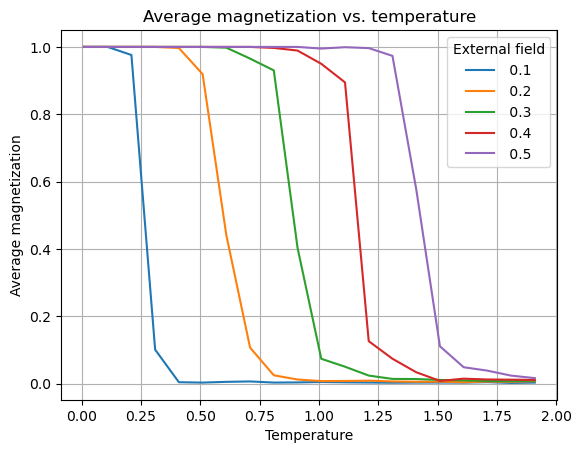

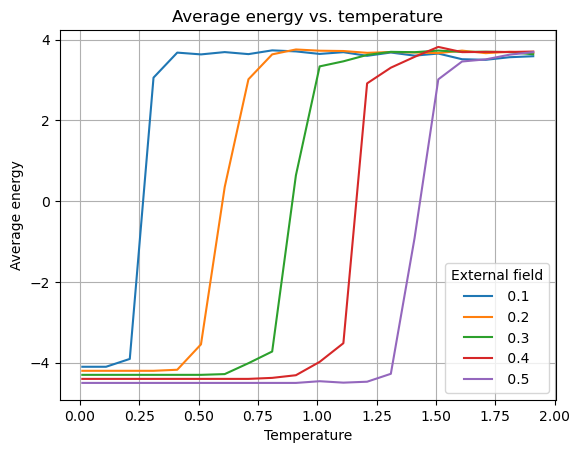

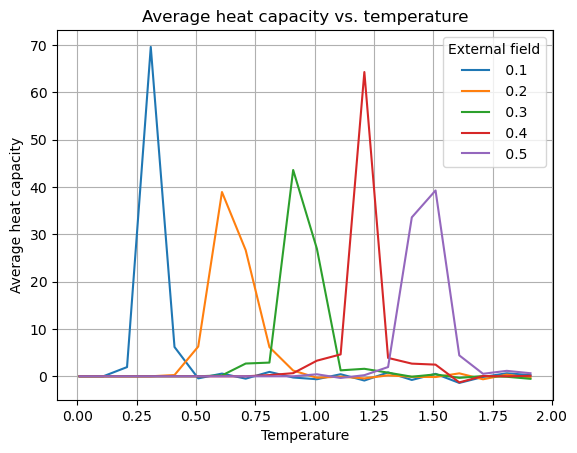

In [205]:
# Plot equilibrium average values as a function of temperature for various 
# external field strengths.
# Start with random state with 75% spins down.
ext_field = np.arange(0.1, 0.6, 0.1)
delta_temp = 0.1
temps = np.arange(0.01, 2., delta_temp)
total_iter = 100
trials = 10
l_all_mag, l_all_energy, l_all_heat_cap = [], [], []
dim = 50

for field_val in ext_field:
    np.random.seed(0)
    lattice2d = np.random.choice([-1, 1], size=(dim, dim), p=[0.75, 0.25])
    l_mag, l_energy, l_heat_cap = [], [], []

    for temp in temps:
        Ising2d = Ising2DLattice(T=temp, J=1, H=field_val)
        prev = lattice2d
        trial_energy, trial_mag = [], []
        for t in range(trials):     # Multiple trials to average out statistical fluctuations.
            for i in range(total_iter):
                current = Ising2d.update_spins(prev)
                if np.array_equal(current, prev):
                    break
                prev = current
            trial_energy.append(Ising2d.net_energy(current) / dim ** 2)
            trial_mag.append(Ising2d.net_magnetization(current) / dim ** 2)
        
        avg_mag = sum(trial_mag) / trials
        avg_energy = sum(trial_energy) / trials
        if not l_energy:
            heat_cap = 0
        else:
            heat_cap = (avg_energy - l_energy[-1]) / delta_temp
        l_mag.append(avg_mag)
        l_energy.append(avg_energy)
        l_heat_cap.append(heat_cap)
        
    l_all_mag.append(l_mag)
    l_all_energy.append(l_energy)
    l_all_heat_cap.append(l_heat_cap)

plt.figure(0)
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_mag[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average magnetization')
plt.title('Average magnetization vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()

plt.figure(1)
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_energy[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average energy')
plt.title('Average energy vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()

plt.figure(2)
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_heat_cap[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average heat capacity')
plt.title('Average heat capacity vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()

---
# Ising model on Cayley graph

In [185]:
class IsingCayley(MetropolisIsing):
    """ 
    Metropolis MC implementation of Ising model on a Cayley graph.
    """
    def nn_alignment(self, v_spins, X_neighbors):
        """ 
        Sum the spin values of the nearest neighbors (nn) for each spin in
        the Cayley graph. This represents the net alignment of the nn spins. 
        Args:
            v_spins (1d array): current state of the spin system
            X_neighbors (2d array): adjacency matrix denoting all edges between spins

        Returns:
            v_nn (1d array): sum of nn spin values
        """
        v_nn = np.ones_like(v_spins)
        v_nn = X_neighbors @ v_nn
        return v_nn
    
    def update_spins(self, v_spins, X_neighbors):
        """ 
        Update spins in the lattice using metropolis algorithm.
        Args:
            v_spins (1d array): current state of the spin system
            X_neighbors (2d array): adjacency matrix denoting all edges between spins
        
        Returns:
            X_result (2d array): updated state of the spin system
        """
        # Calculate change in energy required to flip each spin.
        X_nn = self.nn_alignment(v_spins, X_neighbors)
        X_Ei = - self.J * v_spins * X_nn - self.H * v_spins
        X_Ef = - X_Ei
        X_deltaE = X_Ef - X_Ei

        X_result = v_spins.copy()
        X_flip = - v_spins

        # If deltaE < 0, accept the spin flip.
        X_result[X_deltaE < 0] = X_flip[X_deltaE < 0]

        # If deltaE > 0, accept the spin flip with probability
        # given by Boltzmann factor.
        X_prob = np.random.rand(*v_spins.shape)
        X_prob_c = np.exp(- self.beta * X_deltaE)
        X_result[(X_deltaE > 0) & (X_prob < X_prob_c)] = X_flip[
            (X_deltaE > 0) & (X_prob < X_prob_c)]

        return X_result
    
    def net_energy(self, v_spins, X_neighbors):
        """ 
        Calculate net energy of the spin lattice. This is the sum of all energies
        due to nn interactions and the external magnetic field.
        Args:
            v_spins (2d array): current state of the spin system
            X_neighbors (2d array): adjacency matrix denoting all edges between spins
        
        Returns:
            (float): net energy
        """
        X_nn = self.nn_alignment(v_spins, X_neighbors)
        X_E = -self.J * v_spins * X_nn - self.H * v_spins
        return np.sum(X_E) / 2



iterations: 13


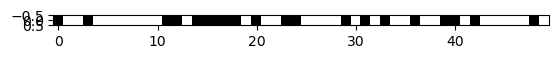

In [188]:
# Change this to visualize the tree in 2d instead of using a chain !!
# Cayley graph where every spin (node) is connected to every other spin.
Ising_all_nn = IsingCayley(T=30, J=1, H=0.0)
np.random.seed(0)

frames = []
dim = 50
v_spins = np.random.choice([-1, 1], size=dim)
v_spins_reshape = v_spins.reshape(1, -1)
X_adjacency = np.ones((dim, dim))
np.fill_diagonal(X_adjacency, 0)

frames.append(v_spins_reshape)
fig = plt.figure()
img = plt.imshow(v_spins_reshape, cmap="gray")

iterations = 200
prev = v_spins
for i in range(iterations):
    current = Ising_all_nn.update_spins(prev, X_adjacency)
    current_reshape = current.reshape(1, -1)
    frames.append(current_reshape)
    if np.array_equal(current, prev):
        break
    prev = current
print("iterations:", i + 1)

# Animate the simulation.
def animate(frame):
    img.set_array(frame)

animation = FuncAnimation(fig, animate, frames=frames, interval=len(frames))
HTML(animation.to_jshtml())

No external field (H = 0).


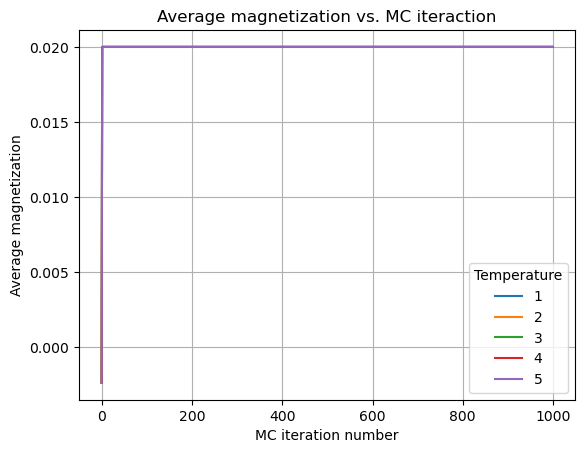

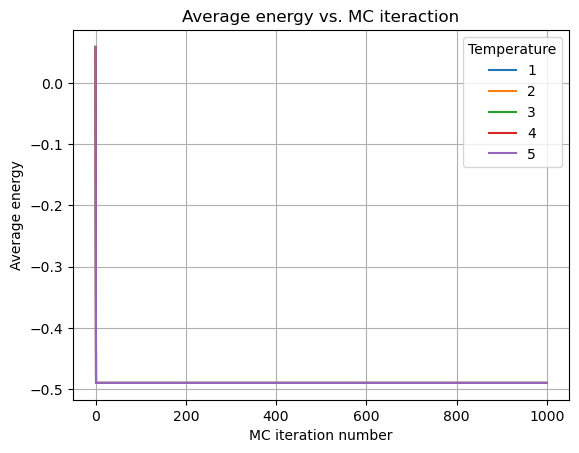

In [193]:
# Plot average values vs MC iteration for various temperatures, with 0 external field.
# Start with a random state with 75% spins down.
temps = np.arange(1, 6, 1)
total_iter = 1000
all_iter = []
all_mag, all_energies = [], []
dim = 50
v_spins = np.random.choice([-1, 1], size=dim)
v_spins_reshape = v_spins.reshape(1, -1)
X_adjacency = np.ones((dim, dim))
np.fill_diagonal(X_adjacency, 0)

for temp in temps:
    Ising_all_nn = IsingCayley(T=temp, J=1, H=0.0)
    np.random.seed(0)
    iteration = np.arange(0, total_iter)
    avg_mag, avg_energy = [], []

    prev = v_spins
    for i in range(total_iter):
        current = Ising_all_nn.update_spins(prev, X_adjacency)
        avg_mag.append(Ising_all_nn.net_magnetization(prev) / (dim ** 2))
        avg_energy.append(Ising_all_nn.net_energy(prev, X_adjacency) / (dim ** 2))
        prev = current

    all_iter.append(iteration)
    all_mag.append(avg_mag)
    all_energies.append(avg_energy)

print("No external field (H = 0).")
plt.figure(0)
for i in range(len(all_iter)):
    temp = temps[i]
    plt.plot(all_iter[i], all_mag[i], label=str(temp))

plt.xlabel('MC iteration number')
plt.ylabel('Average magnetization')
plt.title('Average magnetization vs. MC iteraction')
plt.grid()
plt.legend(title="Temperature")
plt.show()

plt.figure(1)
for i in range(len(all_iter)):
    temp = temps[i]
    plt.plot(all_iter[i], all_energies[i], label=str(temp))

plt.xlabel('MC iteration number')
plt.ylabel('Average energy')
plt.title('Average energy vs. MC iteraction')
plt.grid()
plt.legend(title="Temperature")
plt.show()

C:\Users\ktcy2\AppData\Local\Temp\ipykernel_2420\3417388861.py:45: RuntimeWarning: overflow encountered in exp
  X_prob_c = np.exp(- self.beta * X_deltaE)


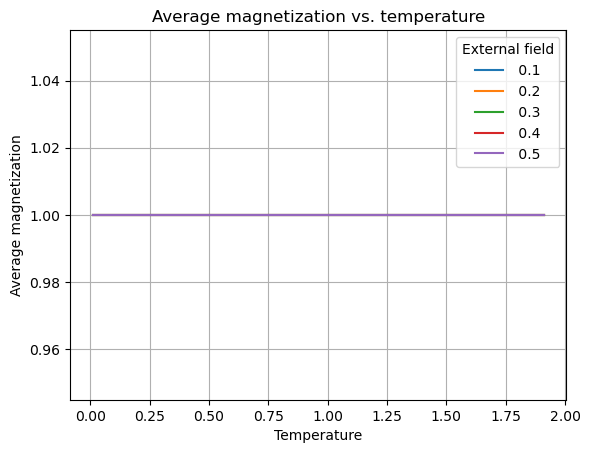

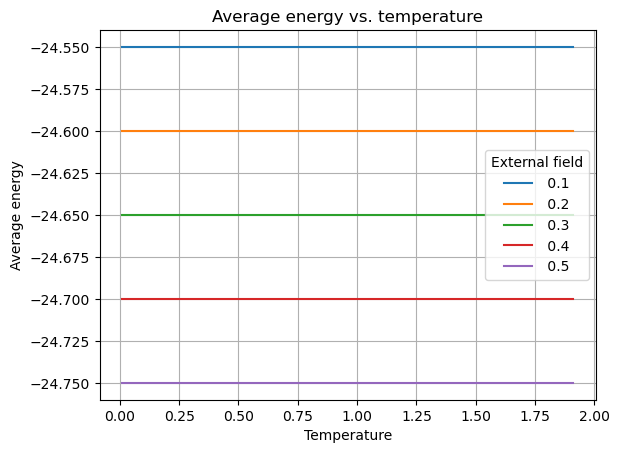

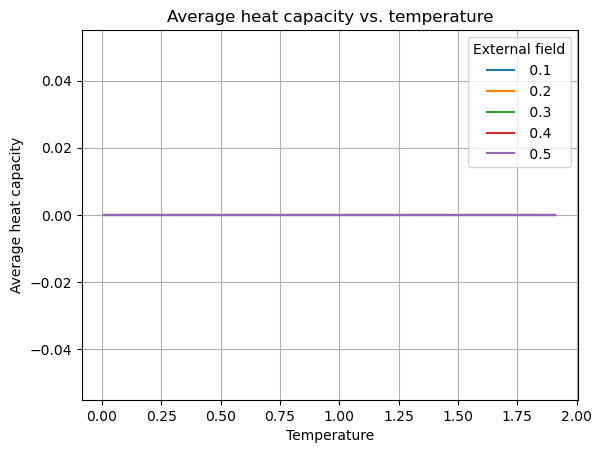

In [195]:
# Plot equilibrium average values as a function of temperature for various 
# external field strengths.
# Start with random state with 75% spins down.
ext_field = np.arange(0.1, 0.6, 0.1)
temps = np.arange(0.01, 2., 0.1)
total_iter = 100
trials = 10
l_all_mag, l_all_energy, l_all_heat_cap = [], [], []
dim = 50

for field_val in ext_field:
    np.random.seed(0)
    v_spins = np.random.choice([-1, 1], size=dim)
    v_spins_reshape = v_spins.reshape(1, -1)
    X_adjacency = np.ones((dim, dim))
    np.fill_diagonal(X_adjacency, 0)
    l_mag, l_energy, l_heat_cap = [], [], []

    for temp in temps:
        Ising_all_nn = IsingCayley(T=temp, J=1, H=field_val)
        prev = lattice2d
        trial_energy, trial_mag = [], []
        for t in range(trials):     # Multiple trials to average out statistical fluctuations.
            for i in range(total_iter):
                current = Ising_all_nn.update_spins(prev, X_adjacency)
                if np.array_equal(current, prev):
                    break
                prev = current
            trial_energy.append(Ising_all_nn.net_energy(current, X_adjacency) / dim ** 2)
            trial_mag.append(Ising_all_nn.net_magnetization(current) / dim ** 2)
        
        avg_mag = sum(trial_mag) / trials
        avg_energy = sum(trial_energy) / trials
        if not l_energy:
            heat_cap = 0
        else:
            heat_cap = (avg_energy - l_energy[-1]) / delta_temp
        l_mag.append(avg_mag)
        l_energy.append(avg_energy)
        l_heat_cap.append(heat_cap)
        
    l_all_mag.append(l_mag)
    l_all_energy.append(l_energy)
    l_all_heat_cap.append(l_heat_cap)

plt.figure(0)
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_mag[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average magnetization')
plt.title('Average magnetization vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()

plt.figure(1)
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_energy[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average energy')
plt.title('Average energy vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()

plt.figure(2)
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_heat_cap[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average heat capacity')
plt.title('Average heat capacity vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()